# Prediction of ICU mortality from patient parameters

This project is based on a dataset that was designed for Women in Data Science Datathon held in February 2020. The dataset provides information about ICU visits of more than 91,000 patients over a one-year timeframe from hundreds of hospitals all over the world. The aim is to create a model to predict the probability of death in ICU using patient parameters such as demographics, comorbidities, lab test results, vital signs, APACHE scores, and other statistics collected during the first 24 hours of ICU stay. An unlabeled dataset containing more than 39,000 samples is also provided to evaluate the performance of the classification model. In addition, a dictionary of features is available. The target variable is 'hospital_death' where 1 means death and 0 means survival.

The dataset has been obtained from **https://www.kaggle.com/c/widsdatathon2020/data**.

I chose this dataset for my project because I expect it to be challenging since it comes from a global competition and it's also relevant to the theme of my systems biology master's program. My goal in this project is to implement data cleaning, preprocessing, and classification techniques to address the challenge of the Datathon.

Before running this code, install numpy, pandas, seaborn, matplotlib, imblearn, and sklearn.

# Import libraries and datasets

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTENC

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier

In [6]:
# read the training set and the unlabeled test set 
X_train = pd.read_csv("training_v2.csv")
unlabeled = pd.read_csv("unlabeled.csv")

# print dimensions
print(X_train.shape)
print(unlabeled.shape)

(91713, 186)
(39308, 186)


In [7]:
# save encounter IDs separately as a vector (to be used later)
unlabeled_encounter_id = unlabeled['encounter_id'] 

# drop features that are not expected to be related to the target label (IDs are not meaningful and 
# readmission status contains all zeros)
X_train.drop(['hospital_id', 'patient_id', 'icu_id', 'readmission_status', 'encounter_id'], 
inplace=True, axis=1)
unlabeled.drop(['hospital_id', 'patient_id', 'icu_id', 'readmission_status', 'encounter_id'], 
inplace=True, axis=1)

# print dimensions
print(X_train.shape)
print(unlabeled.shape)

(91713, 181)
(39308, 181)


In [4]:
# read the dictionary of features
dictionary_ = pd.read_csv("WiDS Datathon 2020 Dictionary.csv")
print(dictionary_.shape)

(188, 6)


In [5]:
# create separate lists of column names based on the data type of the columns
integer_cols = []
binary_cols = []
numeric_cols = []
string_cols = []

for i in range(dictionary_.shape[0]):
    if dictionary_.loc[i, 'Data Type'] == 'integer':
        integer_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'binary':
        binary_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'numeric':
        numeric_cols.append(dictionary_.loc[i, 'Variable Name'])

    if dictionary_.loc[i, 'Data Type'] == 'string':
        string_cols.append(dictionary_.loc[i, 'Variable Name'])

# Data Exploration

<ipython-input-6-d7ab432d2653>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


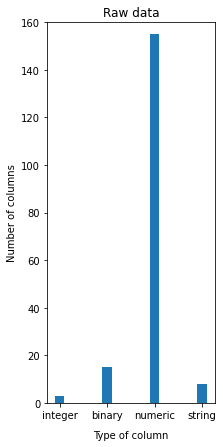

In [6]:
# find how many coiumns of each data type are present in the training dataset
integer_cols_X_train = []
binary_cols_X_train = []
numeric_cols_X_train = []
string_cols_X_train = []

for col_name in X_train.columns.to_list():
    if col_name in integer_cols:
        integer_cols_X_train.append(col_name)

    if col_name in binary_cols:
        binary_cols_X_train.append(col_name)    
    
    if col_name in numeric_cols:
        numeric_cols_X_train.append(col_name)

    if col_name in string_cols:
        string_cols_X_train.append(col_name)

# make a bar plot of number of columns vs type
fig, ax = plt.subplots(figsize=(3, 7))

ax.bar(['integer', 'binary', 'numeric', 'string'], [len(integer_cols_X_train), 
len(binary_cols_X_train), len(numeric_cols_X_train), len(string_cols_X_train)], width=0.2)
plt.xlabel('Type of column', labelpad=10)
plt.ylim(0, 160)
plt.ylabel('Number of columns')
plt.title('Raw data')

fig.show()        

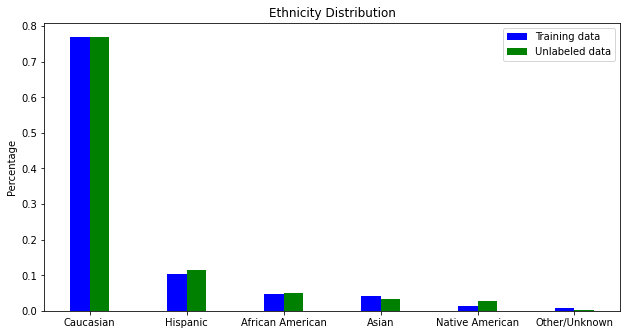

In [7]:
# make a bar plot of ethnicity distribution in the training and unlabeled datasets
cat_variable = 'ethnicity'
labels = list(X_train[cat_variable].dropna().unique())
x = np.arange(len(labels))
sizes_X = X_train[cat_variable].value_counts()/len(X_train)
sizes_unlabeled = unlabeled[cat_variable].value_counts()/len(unlabeled)
width = 0.2

fig = plt.figure(figsize=(8, 4))
ax = fig.add_axes([0,0,1,1])
ax.bar(x - width/2, sizes_X, color = 'b', width=width, label='Training data')
ax.bar(x + width/2, sizes_unlabeled, color = 'g', width=width, label='Unlabeled data')

ax.set_ylabel('Percentage')
ax.set_title('Ethnicity Distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=0)
plt.show()

# Step 1. Impute weight and height according to gender-wise mean values 

Height and weight are expected to be normally distributed in the population and majority of the people are expected to have a height and weight value that is close to the mean value of the population.

In [8]:
# impute height and weight with average values assuming that males are taller and heavier than females
X_train["height"] = np.where((X_train.height.isna() & (X_train.gender == 'F')), 160, X_train["height"])
X_train["height"] = np.where((X_train.height.isna() & (X_train.gender == 'M')), 180, X_train["height"])
X_train["height"] = np.where((X_train.height.isna() & (X_train.gender.isna())), 170, X_train["height"])
X_train["weight"] = np.where((X_train.height.isna() & (X_train.gender == 'F')), 65, X_train["weight"])
X_train["weight"] = np.where((X_train.height.isna() & (X_train.gender == 'M')), 82, X_train["weight"])
X_train["weight"] = np.where((X_train.height.isna() & (X_train.gender.isna())), 74, X_train["weight"])

unlabeled["height"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'F')), 160, unlabeled["height"])
unlabeled["height"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'M')), 180, unlabeled["height"])
unlabeled["height"] = np.where((unlabeled.height.isna() & (unlabeled.gender.isna())), 170, unlabeled["height"])
unlabeled["weight"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'F')), 65, unlabeled["weight"])
unlabeled["weight"] = np.where((unlabeled.height.isna() & (unlabeled.gender == 'M')), 82, unlabeled["weight"])
unlabeled["weight"] = np.where((unlabeled.height.isna() & (unlabeled.gender.isna())), 74, unlabeled["weight"])

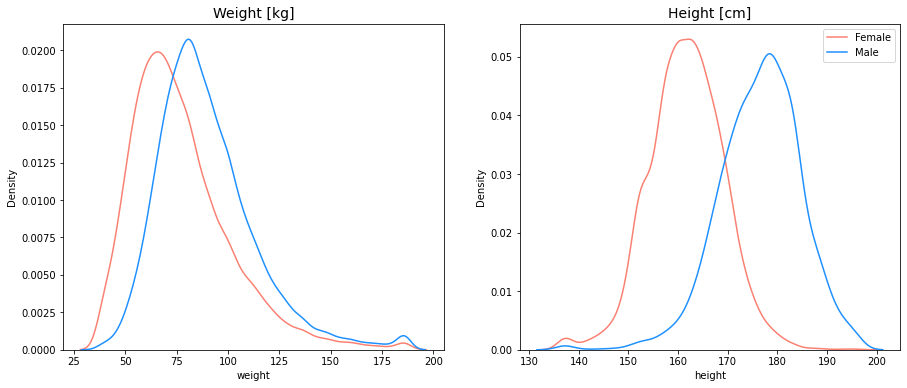

In [9]:
# Check that the distribution of height and weight in the population is approximately normal
# Plot univariate or bivariate distributions using kernel density estimation.
# A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations 
# in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density 
# curve.

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.kdeplot(X_train[X_train.gender == 'F'].weight, label='Female', color='salmon', ax=ax[0], bw_adjust=1.2,
legend=True)
sns.kdeplot(X_train[X_train.gender == 'M'].weight, label='Male', color='dodgerblue', ax=ax[0], bw_adjust=1.2,
legend=True)
ax[0].set_title('Weight [kg]', fontsize=14)

sns.kdeplot(X_train[X_train.gender == 'F'].height, label='Female', color='salmon', ax=ax[1], bw_adjust=1.8,
legend=True)
sns.kdeplot(X_train[X_train.gender == 'M'].height, label='Male', color='dodgerblue', ax=ax[1], bw_adjust=2,
legend=True)
ax[1].set_title('Height [cm]', fontsize=14)
plt.legend()
plt.show()

# Step 2. Drop features and samples containing more than 30% missing values 

Columns and rows containing more than 30% missing values are dropped before imputation because it is difficult to impute higher percentage of missing values.

Text(0.5, 0, 'Percentage of missing values')

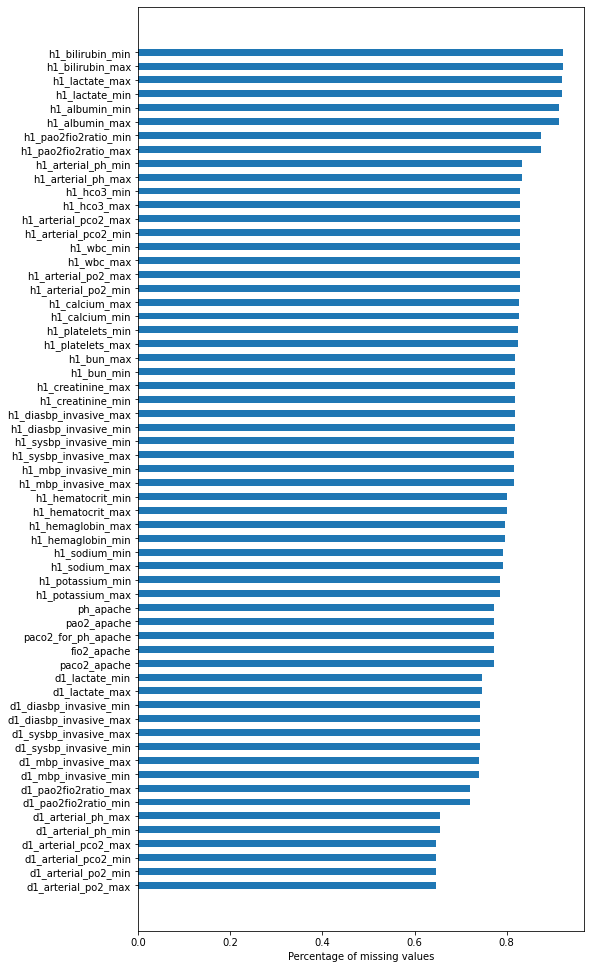

In [10]:
# find the number of missing values in each column and divide by column length
lst = X_train.isna().sum() / len(X_train)

# sort the percentages of missing values in ascending order
sorted_lst = lst.sort_values(ascending=True)

# make a bar plot of column names versus percentage of missing values
plt.figure(figsize=(8,17))
plt.barh(sorted_lst[120:181].index, sorted_lst[120:181], height=0.5)
plt.xlabel("Percentage of missing values")

In [11]:
# create a dataframe containing the percentage of missing values in each column
p = pd.DataFrame(lst)

# reset_index: the old index is added as a column, and a new sequential index is used
p.reset_index(inplace=True)

# find columns containing more than 30% missing values
p.columns = ['a', 'b']
low_count = p[p['b'] > 0.3]
todelete = low_count['a'].values

# drop columns containing more than 30% missing values from the training and unlabeled datasets
X_train.drop(todelete, axis=1, inplace=True)
unlabeled.drop(todelete, axis=1, inplace=True)

# check dimensions
print(X_train.shape)
print(unlabeled.shape)

(91713, 107)
(39308, 107)


<ipython-input-12-83beaed4bfc1>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


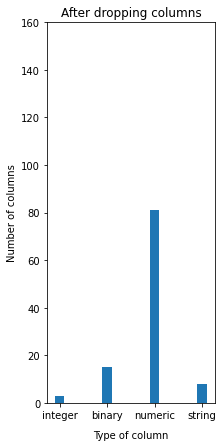

In [12]:
# find how many coiumns of each data type are present in the training dataset
integer_cols_X_train = []
binary_cols_X_train = []
numeric_cols_X_train = []
string_cols_X_train = []

for col_name in X_train.columns.to_list():
    if col_name in integer_cols:
        integer_cols_X_train.append(col_name)

    if col_name in binary_cols:
        binary_cols_X_train.append(col_name)    
    
    if col_name in numeric_cols:
        numeric_cols_X_train.append(col_name)

    if col_name in string_cols:
        string_cols_X_train.append(col_name)

# make a bar plot of number of columns vs type
fig, ax = plt.subplots(figsize=(3, 7))

ax.bar(['integer', 'binary', 'numeric', 'string'], [len(integer_cols_X_train), 
len(binary_cols_X_train), len(numeric_cols_X_train), len(string_cols_X_train)], width=0.2)
plt.ylim(0, 160)
plt.xlabel('Type of column', labelpad=10)
plt.ylabel('Number of columns')
plt.title('After dropping columns')

fig.show() 

In [13]:
# drop rows ontaining more than 30% missing values from the training dataset
X_train.dropna(thresh=X_train.shape[1]*0.3, inplace=True)

# print dimensions
X_train.shape

(91677, 107)

# Plot distributions of numeric features to find any observable differences between training and unlabeled datasets

<AxesSubplot:>

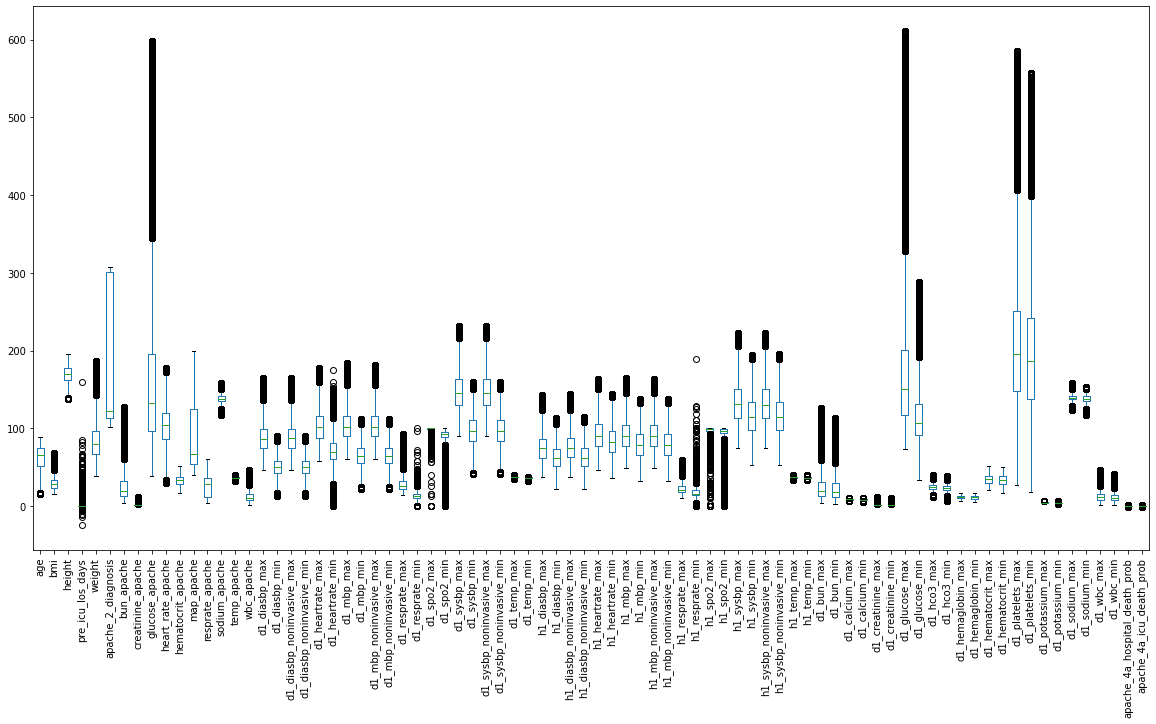

In [13]:
# Remove 'apache_3j_diagnosis' because its distribution is deviating a lot from the rest
# this makes it easier to visualize other distributions
n = numeric_cols_X_train.copy()
n.remove('apache_3j_diagnosis')

# make a box plot of the distributions of the numeric features of the training dataset
X_train.boxplot(column=n, ax=None, 
fontsize=None, rot=90, grid=False, figsize=(20, 10), layout=None)

<AxesSubplot:>

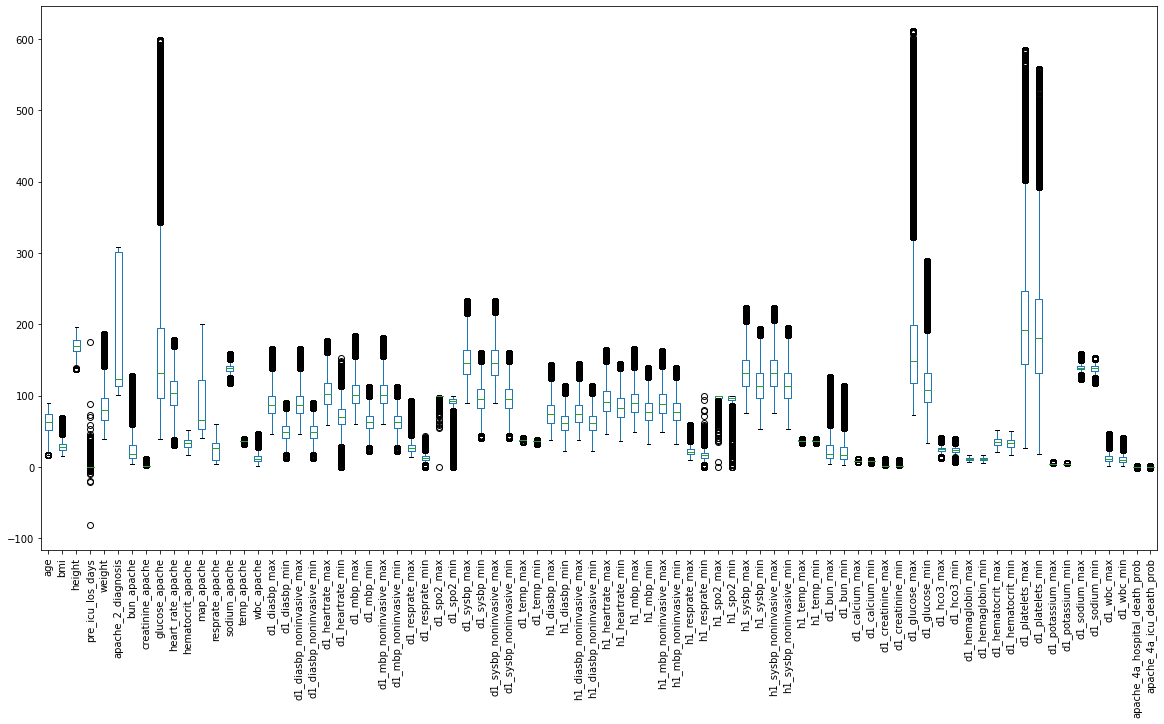

In [14]:
# make a box plot of the distributions of the numeric features of the unlabeled dataset
unlabeled.boxplot(column=n, ax=None, 
fontsize=None, rot=90, grid=False, figsize=(20,10), layout=None)

The plotted distributions show no observable dfferences between training and unlabeled datasets.

# Step 3. Encode string features as ordinal integers

Encoding is needed because classifiers cannot handle data in string format. There are two ways to encode string features: ordinal encoding and one-hot encoding.

I have chosen ordinal encoding because
* One-hot encoding increases the number of features and that would increase my computational load
* Random forest algorithm that I am planning to use is not affected by the ordinal nature of the features

Before ordinal encoding can be done, empty boxes in the string columns have to be replaced with 'None'.

In [14]:
# for string columns, replace empty boxes with "None"
for col_name in string_cols:
    if col_name in X_train.columns.to_list():
        X_train[col_name].where(pd.notnull(X_train[col_name]), None, inplace=True)

    if col_name in unlabeled.columns.to_list():
        unlabeled[col_name].where(pd.notnull(unlabeled[col_name]), None, inplace=True)

In [15]:
# define ordinal encoder
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

# fit the encoder on the training dataset and transform the training and unlabeled datasets
for col_name in string_cols:
    if col_name in X_train.columns.to_list():
        enc.fit(X_train[[col_name]])
        X_train[col_name] = enc.transform(X_train[[col_name]])

    if col_name in unlabeled.columns.to_list():
        unlabeled[col_name] = enc.transform(unlabeled[[col_name]])

In [16]:
# convert the data types of all columns to float 
X_train = X_train.astype('float32')
unlabeled = unlabeled.astype('float32')

# check dimensions
print(X_train.shape)
print(unlabeled.shape)

(91677, 107)
(39308, 107)


# Step 4. Impute missing values with k nearest neighbors

K nearest neighbors imputation is an algorithm in which missing values are imputed using the mean value from k nearest neighbors. I chose this algorithm because patients with similar conditions are expected to have similar parameters as well. Other reasons are
* Features in my dataset have different data types and KNN can handle this problem
* Real distribution of features in my dataset is unknown and KNN does not require this information to be able to provide reasonable results

In [17]:
# define KNN Imputer
# neighbors = 5, weighted by the inverse of their distance, metric: NAN Euclidean
# NAN Euclidean metric: ignores feature coordinates with a missing value and scales up 
# the weight of the remaining coordinates
knn_imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights='distance', metric='nan_euclidean', 
copy=False)

# fit the imputer on the training dataset
knn_imputer.fit(X_train)

# transform the training and unlabeled datasets
knn_imputer.transform(X_train)
knn_imputer.transform(unlabeled)

array([[ 0.        , 56.        , 21.10244   , ...,  0.        ,
         7.        ,  4.        ],
       [ 0.        , 59.112823  , 19.500595  , ...,  0.        ,
         7.        ,  4.        ],
       [ 0.        , 66.        , 32.518597  , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , 71.        , 23.01038   , ...,  1.        ,
         9.        ,  0.        ],
       [ 0.        , 57.        , 32.98795   , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19734402, 66.        , 23.183392  , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [18]:
# save the processed data as csv files
X_train.to_pickle("X_train_knn.csv")
unlabeled.to_pickle("unlabeled_knn.csv")

In [46]:
# read the processed data from csv files
X_train = pd.read_pickle("X_train_knn.csv")
unlabeled = pd.read_pickle("unlabeled_knn.csv")

# Step 5. Remove highly correlated features

It is good to remove highly correlated features because
* It reduces computational expense; less features mean a smaller dataset
* Correlated features may reduce performance of some classification algorithms

In [19]:
# create a list of column names of the numeric features
num_feature = []

for col_name in numeric_cols:
    if col_name in X_train.columns.to_list():
        num_feature.append(col_name)

# create a correlation matrix of the numeric columns 
corr_matrix = X_train[num_feature].corr().abs()

<AxesSubplot:>

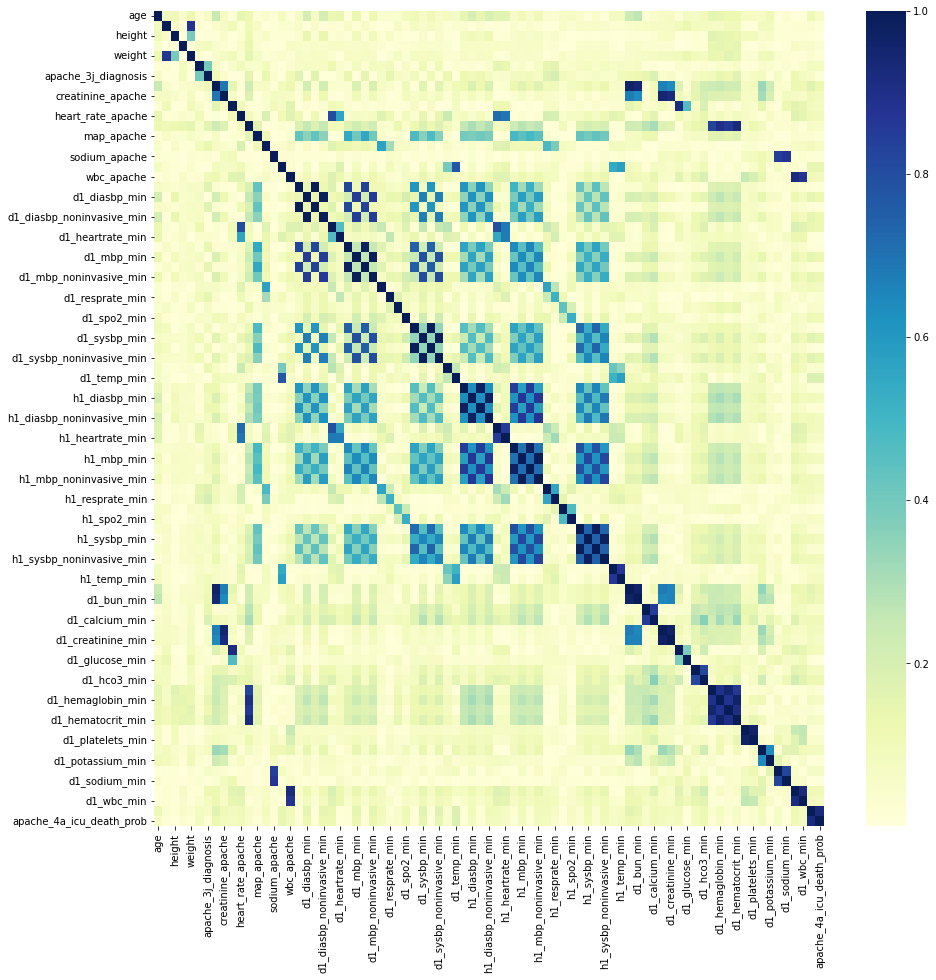

In [20]:
# create a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, cmap="YlGnBu")

In [21]:
# select upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

Text(0, 0.5, 'number of columns to drop')

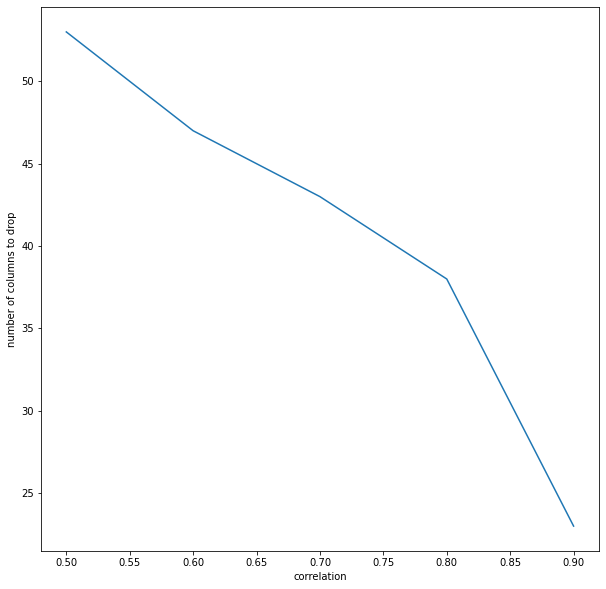

In [22]:
# plot a graph of number of columns to drop vs correlation
corr = []
to_drop_columns = []

for i in np.arange(0.5, 1, 0.1):
    to_drop = [column for column in upper.columns if any(upper[column] > i)]
    corr.append(i)
    to_drop_columns.append(len(to_drop))

plt.subplots(figsize=(10, 10))
plt.plot(corr, to_drop_columns)
plt.xlabel('correlation')
plt.ylabel('number of columns to drop')

In [23]:
# A correlation threshold of 80% is chosen because this threshold removes most correlation without 
# removing too many features.

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop columns that have more than 80% correlation to other columns
X_train.drop(to_drop, inplace=True, axis=1)
unlabeled.drop(to_drop, inplace=True, axis=1)

# Check dimensions after removing correlated columns
print(X_train.shape)
print(unlabeled.shape)

(91677, 69)
(39308, 69)


<ipython-input-24-2d5201191ed6>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


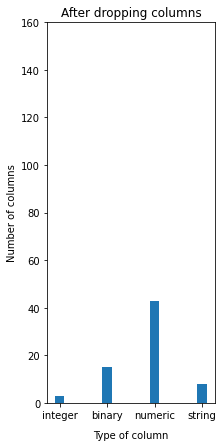

In [24]:
# find how many coiumns of each data type are present in the training dataset
integer_cols_X_train = []
binary_cols_X_train = []
numeric_cols_X_train = []
string_cols_X_train = []

for col_name in X_train.columns.to_list():
    if col_name in integer_cols:
        integer_cols_X_train.append(col_name)

    if col_name in binary_cols:
        binary_cols_X_train.append(col_name)    
    
    if col_name in numeric_cols:
        numeric_cols_X_train.append(col_name)

    if col_name in string_cols:
        string_cols_X_train.append(col_name)

# make a bar plot of the number of columns vs type
fig, ax = plt.subplots(figsize=(3, 7))

ax.bar(['integer', 'binary', 'numeric', 'string'], [len(integer_cols_X_train), 
len(binary_cols_X_train), len(numeric_cols_X_train), len(string_cols_X_train)], width=0.2)
plt.ylim(0, 160)
plt.xlabel('Type of column', labelpad=10)
plt.ylabel('Number of columns')
plt.title('After dropping columns')

fig.show()

# Step 6. Remove outliers

Outlier removal is important because outliers might affect classifier training. I chose the isolation forest algorithm to implement this step because
* Features in my dataset have different data types and the isolation forest algorithm can handle this problem
* Real distribution of features is unknown and the isolation forest does not require this information to be able to provide reasonable results
* There is no need to scale the data first for the isolation forest to be able to identify outliers

In [25]:
# Define isolation forest
# n_estimators: The number of trees in the forest.
# max_samples: The number of samples to draw from the training dataset to train each tree.
# contamination: The proportion of outliers in the training dataset.
# max_features: The number of features to draw from training dataset to train each tree.
# n_jobs: The number of jobs to run in parallel. 
iso = IsolationForest(n_estimators=1000, max_samples=1000, contamination='auto', max_features=10, 
n_jobs=-1, random_state=20)

# Fit isolation forest on the training dataset
iso.fit(X_train)

# Find anomaly scores for each sample in the training dataset
# Negative scores correspond to anomalies - the more negative the more anomalous
scores = iso.decision_function(X_train)

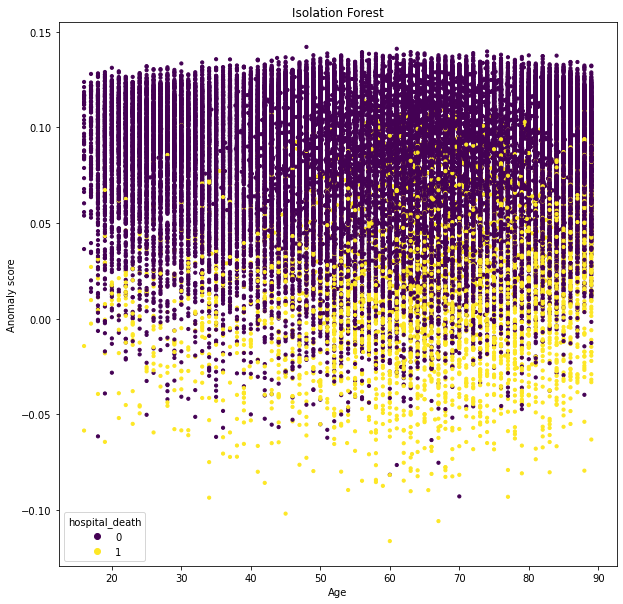

In [26]:
# Make a scatter plot of anomaly scores versus age and color by 'hospital_death'
plt.subplots(figsize=(10, 10))
plt.title("Isolation Forest")

b = plt.scatter(X_train['age'], scores, c=X_train['hospital_death'].astype('int32'), s=10)

plt.axis('tight')
plt.legend(handles=b.legend_elements()[0], labels=(0,1), title="hospital_death")
plt.xlabel('Age')
plt.ylabel('Anomaly score')
plt.show()

In [27]:
# Add the anomaly scores to the training data matrix as an additional column
X_train_scores = X_train
X_train_scores['scores'] = scores

# Drop samples that have a score of less than -0.01 and a 'hospital_death' value of 0
# This is done because there is a low density of points below -0.01 as observed from the plot
# Only the 'hospital_death' = 0 samples are dropped because 'hospital_death' = 1 samples are 
# already very few in the dataset and most of them have negative anomaly scores 
indexes_to_drop = X_train_scores[(X_train_scores['scores'] < -0.01) & 
(X_train_scores['hospital_death'] == 0.0)].index

# Drop the outliers from the training dataset
X_train_scores.drop(indexes_to_drop, inplace=True)

# Drop the scores column from the training dataset
scores = X_train_scores['scores']
X_train = X_train_scores.drop(['scores'], axis=1)

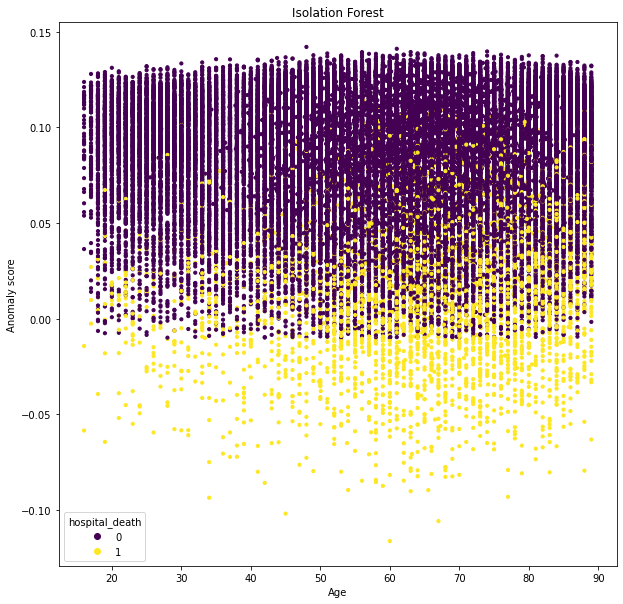

In [28]:
# Make a scatter plot of anomaly scores versus age and color by 'hospital_death'
plt.subplots(figsize=(10, 10))
plt.title("Isolation Forest")

b = plt.scatter(X_train['age'], scores, c=X_train['hospital_death'].astype('int32'), s=10)

plt.axis('tight')
plt.legend(handles=b.legend_elements()[0], labels=(0,1), title="hospital_death")
plt.xlabel('Age')
plt.ylabel('Anomaly score')
plt.show()

In [29]:
# Check dimensions after dropping outliers
print(X_train.shape)
print(unlabeled.shape)

(91311, 69)
(39308, 69)


# Step 7. Range scaling

Scaling the dataset is needed for PCA. Scaling is done with Min Max Scaler algorithm which scales and translates each feature such that it is in the range between zero and one. I have chosen this algorithm because
* Features in my dataset have different data types and the isolation forest algorithm can handle this problem
* Real distribution of features is unknown and the isolation forest does not require this information to be able to provide reasonable results

In [30]:
# Define Min Max Scaler
scalar = MinMaxScaler()

# Fit the scaler on the training dataset
scalar.fit(X_train)

# Transform the training and unlabeled datasets using the fitted scaler
X_train_scaled = pd.DataFrame(scalar.transform(X_train), columns=X_train.columns)
unlabeled_scaled = pd.DataFrame(scalar.transform(unlabeled), columns=unlabeled.columns)

In [31]:
# save the processed data as csv files
X_train_scaled.to_pickle("X_train_scaled.csv")
unlabeled_scaled.to_pickle("unlabeled_scaled.csv")

In [53]:
# read the processed data from csv files
X_train_scaled = pd.read_pickle("X_train_scaled.csv")
unlabeled_scaled = pd.read_pickle("unlabeled_scaled.csv")

# Step 8. Principal Component Analysis (PCA)

PCA is useful for observing the main sources of variance in the data.

In [32]:
# Define PCA
pca = PCA(random_state=20)

# Fit and transform the training dataset
components = pca.fit_transform(X_train_scaled)

<ipython-input-33-7b4019318a98>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


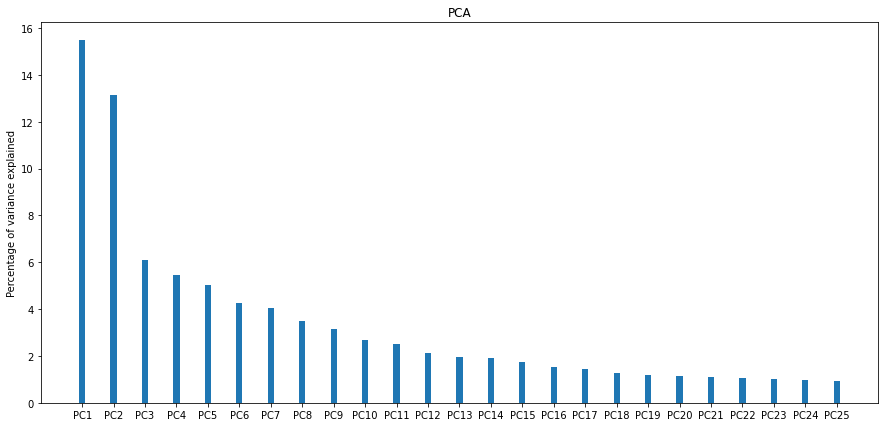

In [33]:
# Plot the percentage of variance explained for each PC
fig, ax = plt.subplots(figsize=(15, 7))

ax.bar([f"PC{i+1}" for i in range(25)], pca.explained_variance_ratio_[0:25]*100, width=0.2)
plt.ylabel('Percentage of variance explained')
plt.title('PCA')

fig.show()

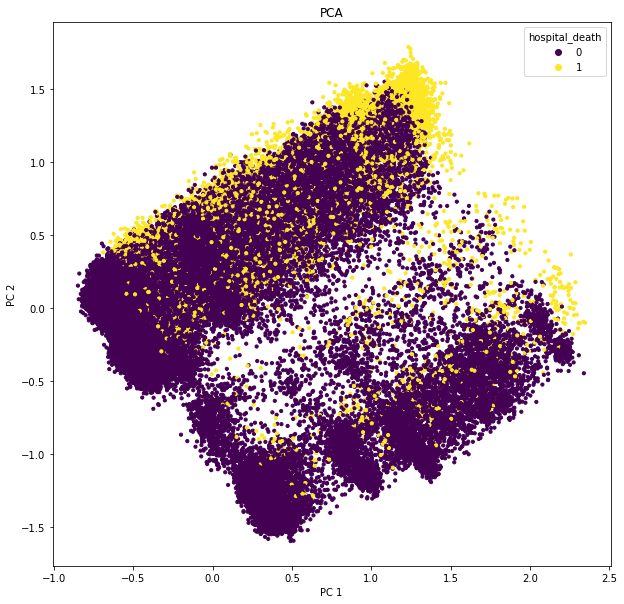

In [34]:
# Make a plot of PC 2 versus PC 1 and color the points by 'hospital_death' 
plt.subplots(figsize=(10, 10))
plt.title("PCA")

b = plt.scatter(components[:,0], components[:,1], c=X_train['hospital_death'].astype('int32'), s=10)

plt.axis('tight')
plt.legend(handles=b.legend_elements()[0], labels=(0,1), title="hospital_death")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

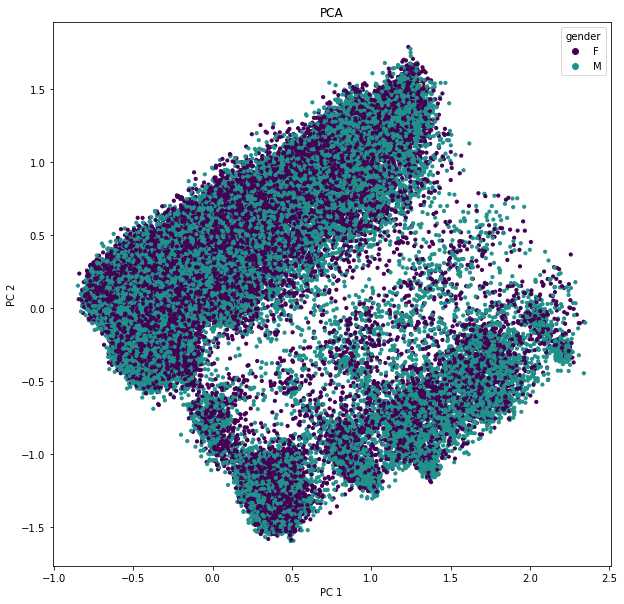

In [35]:
# Make a plot of PC 2 versus PC 1 and color the points by 'gender' 
plt.subplots(figsize=(10, 10))
plt.title("PCA")

b = plt.scatter(components[:,0], components[:,1], c=X_train['gender'].astype('int32'), s=10)

plt.axis('tight')
plt.legend(handles=b.legend_elements()[0], labels=('F','M'), title="gender")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

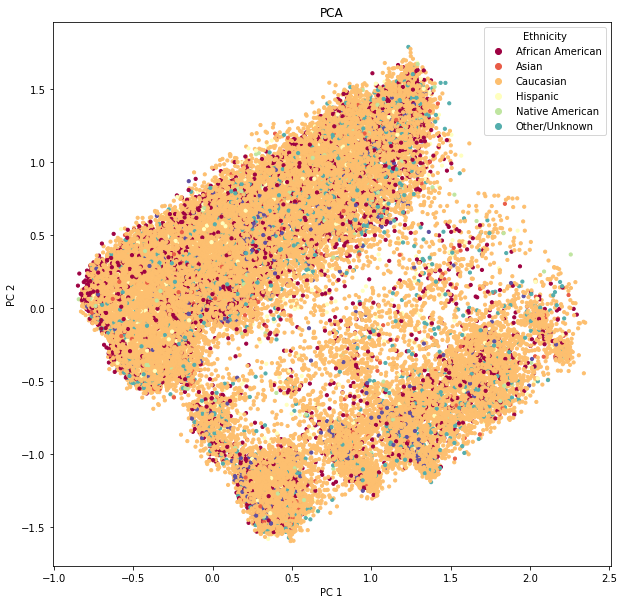

In [36]:
# Make a plot of PC 2 versus PC 1 and color the points by 'ethnicity' 
plt.subplots(figsize=(10, 10))
plt.title("PCA")

b = plt.scatter(components[:,0], components[:,1], c=X_train['ethnicity'].astype('int32'), s=10, 
cmap="Spectral")

plt.axis('tight')
plt.legend(handles=b.legend_elements()[0], labels=('African American','Asian',
'Caucasian','Hispanic','Native American','Other/Unknown'), title="Ethnicity")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

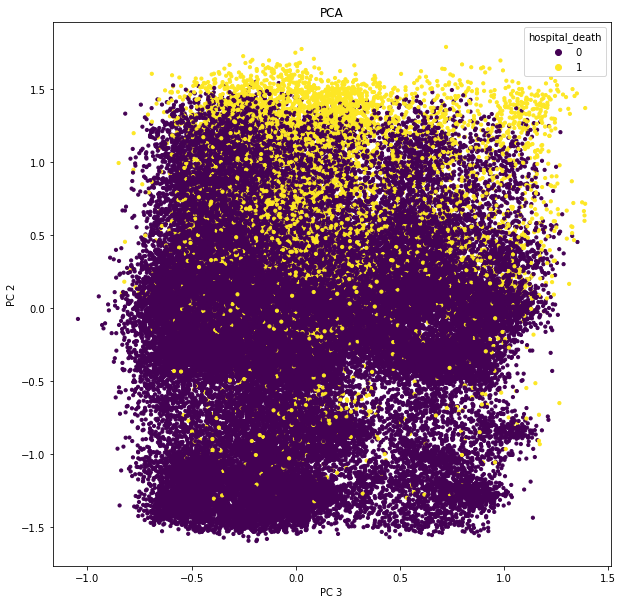

In [37]:
# Make a plot of PC 2 versus PC 3 and color the points by 'hospital_death' 
plt.subplots(figsize=(10, 10))
plt.title("PCA")

b = plt.scatter(components[:,2], components[:,1], c=X_train['hospital_death'].astype('int32'), s=10)

plt.axis('tight')
plt.legend(handles=b.legend_elements()[0], labels=(0,1), title="hospital_death")
plt.xlabel('PC 3')
plt.ylabel('PC 2')
plt.show()

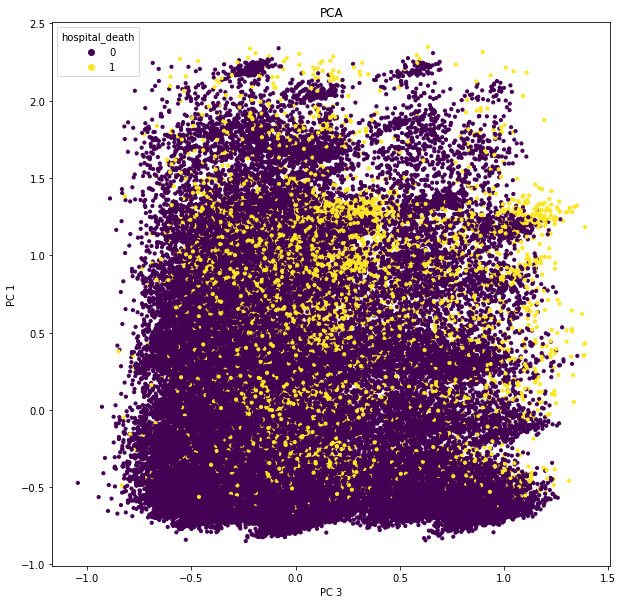

In [38]:
# Make a plot of PC 1 versus PC 3 and color the points by 'hospital_death' 
plt.subplots(figsize=(10, 10))
plt.title("PCA")

b = plt.scatter(components[:,2], components[:,0], c=X_train['hospital_death'].astype('int32'), s=10)

plt.axis('tight')
plt.legend(handles=b.legend_elements()[0], labels=(0,1), title="hospital_death")
plt.xlabel('PC 3')
plt.ylabel('PC 1')
plt.show()

From the PCA plots, some clustering of points with respect to 'hospital_death' is observed in the PC 1 vs PC 2 plot and the PC 2 vs PC 3 plot. No clustering with respect to gender or ethnicity is observed.

# Step 9. Augment data to overcome class imbalance

The training dataset contains a lot more samples where 'hospital_death' = 0 compared to those where 'hospital_death' = 1 and this might result in a bias when training the classifier. Therefore, this class imbalance problem has to be resolved by data augmentation before the classifier can be trained. 

In [39]:
# extract the 'hospital_death' column from the training dataset and store it separately as a vector
y_train = X_train['hospital_death']

# drop the 'hospital_death' column from the training and unlabeled datasets
X_train.drop('hospital_death', inplace=True, axis=1)
unlabeled.drop('hospital_death', inplace=True, axis=1)

# find the proportion of positive and non-positive targets in the label vector
# this shows that the training dataset is highly unbalanced
y_train.value_counts() / len(y_train)

0.0    0.913384
1.0    0.086616
Name: hospital_death, dtype: float64

In [40]:
# make a list of column names that are categorical
# all columns that are not numeric are categorical
cat_feature = []

for i, col_name in enumerate(X_train.columns.to_list()):
    if col_name not in numeric_cols:
        cat_feature.append(i)

In [41]:
# Before doing data augmentation, the training dataset has to be split up into 8 smaller subsets 
# because my computer memory is not big enough to handle the whole dataset at once 

# train_test_split is a function that splits the dataset into two smaller subsets and it can be used
# to create subsets before data augmentation
# test_size=0.5 means the two smaller subsets are created equal in size
# stratify=y_train means the two smaller subsets contain equal proporotions of 
# positive and non-positive targets
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train, 
random_state=20)
X_train11, X_train21, y_train11, y_train21 = train_test_split(X_train1, y_train1, test_size=0.5, 
stratify=y_train1, random_state=20)
X_train12, X_train22, y_train12, y_train22 = train_test_split(X_train2, y_train2, test_size=0.5, 
stratify=y_train2, random_state=20)
X_train111, X_train211, y_train111, y_train211 = train_test_split(X_train11, y_train11, test_size=0.5, 
stratify=y_train11, random_state=20)
X_train121, X_train221, y_train121, y_train221 = train_test_split(X_train21, y_train21, test_size=0.5, 
stratify=y_train21, random_state=20)
X_train112, X_train212, y_train112, y_train212 = train_test_split(X_train12, y_train12, test_size=0.5, 
stratify=y_train12, random_state=20)
X_train122, X_train222, y_train122, y_train222 = train_test_split(X_train22, y_train22, test_size=0.5, 
stratify=y_train22, random_state=20)

The Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTE-NC) algorithm is used to perform data augmentation. It is a method which oversamples the minority class and increases the number of samples in the minority class until they become equal to the number of samples in the majority class. It works as follows:
* Find k nearest neighbors of a sample from the minority class. 
* Randomly select one neighbor from the k nearest neighbors and create a synthetic sample at a randomly selected point between the two samples. 
* The categorical features of the synthetic sample are decided by picking the most frequent categorical features of the nearest neighbors.

I have chosen the SMOTE-NC algorithm to do data augmentation because:
* Features in my dataset have different data types and the SMOTE-NC algorithm can handle this problem
* Real distribution of features is unknown and the SMOTE-NC algorithm does not require this information to be able to provide reasonable results

In [42]:
# define smote-nc
sm = SMOTENC(categorical_features=cat_feature, n_jobs=-1, random_state=20)

# fit smote-nc on subsets of the training data and resample
X_train111, y_train111 = sm.fit_resample(X_train111, y_train111)
X_train211, y_train211 = sm.fit_resample(X_train211, y_train211)
X_train121, y_train121 = sm.fit_resample(X_train121, y_train121)
X_train221, y_train221 = sm.fit_resample(X_train221, y_train221)
X_train112, y_train112 = sm.fit_resample(X_train112, y_train112)
X_train212, y_train212 = sm.fit_resample(X_train212, y_train212)
X_train122, y_train122 = sm.fit_resample(X_train122, y_train122)
X_train222, y_train222 = sm.fit_resample(X_train222, y_train222)

In [43]:
# print the proportions of positive and non-positive targets in the resampled subsets
# to check that they are 50%-50% 
print(y_train111.value_counts() / len(y_train111))
print(y_train211.value_counts() / len(y_train211))
print(y_train121.value_counts() / len(y_train121))
print(y_train221.value_counts() / len(y_train221))
print(y_train112.value_counts() / len(y_train112))
print(y_train212.value_counts() / len(y_train212))
print(y_train122.value_counts() / len(y_train122))
print(y_train222.value_counts() / len(y_train222))

0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64
0.0    0.5
1.0    0.5
Name: hospital_death, dtype: float64


In [44]:
# combine the subsets of the training data into one big matrix
X_train = pd.concat([X_train111, X_train211, X_train121, X_train221, 
X_train112, X_train212, X_train122, X_train222])
y_train = pd.concat([y_train111, y_train211, y_train121, y_train221, 
y_train112, y_train212, y_train122, y_train222])

# check dimensions after concatenation
print(X_train.shape)
print(y_train.shape)

(166804, 68)
(166804,)


In [45]:
# save the processed data as csv files
X_train.to_pickle("X_train_smote.csv")
unlabeled.to_pickle("unlabeled_smote.csv")
y_train.to_pickle("y_train_smote.csv")

In [2]:
# read the processed data from csv files
X_train = pd.read_pickle("X_train_smote.csv")
y_train = pd.read_pickle("y_train_smote.csv")
unlabeled = pd.read_pickle("unlabeled_smote.csv")

# Step 10. Classification

For building a classification model, I have chosen to use the Random Forest classfier because
* Features in my dataset have different data types and the RF algorithm can handle this problem
* Real distribution of features is unknown and the RF algorithm does not require this information to be able to provide reasonable results
* Scaling data is not required for the RF algorithm to work
* RF algorithm incorporates feature selection so I don't have to do it separately
* Overfitting can be controlled in RF by selecting the right hyperparameters
* It’s a non-linear method so the data doesn't have to be linearly separable
* RF algorithm can easily handle large datasets since each tree is trained on a subset of the data

Before defining the RF classifier, I will find the best value for the minimum number of samples required to split an internal node, which is a hyperparamter that controls overfitting. To find this best value, I will use grid-search with 5-fold cross-validation.

In [3]:
# define RF classifier without hyperparameters
RF_classifier = RandomForestClassifier(random_state=20)

# n_estimators: The number of trees in the forest.
# It is set to 1500 which is a large enough value to provide reasonable results
n_estimators = [1500]

# min_samples_split: The minimum number of samples required to split an internal node.
# the best value will be chosen from 3 options
min_samples_split = [20, 50]

# define 5-fold cross-validation
# stratified folds are made by preserving the percentage of samples for each class 
cv = StratifiedKFold(n_splits=5)

# define a grid for grid search
grid = dict(n_estimators=n_estimators, min_samples_split=min_samples_split)

# define grid search
# GridSearchCV exhaustively generates candidates from a grid of parameter values
# 'roc_auc': Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) 
# from prediction scores.
grid_search = GridSearchCV(estimator=RF_classifier, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc')

# fit the grid search on the training dataset
grid_result = grid_search.fit(X_train, y_train)

# print the results of grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# define a Random Forest model using the best parameter values obtained from the grid search
RF_classifier = RandomForestClassifier(n_estimators=grid_result.best_params_['n_estimators'],
                min_samples_split=grid_result.best_params_['min_samples_split'],
                random_state=20)

Best: 0.969452 using {'min_samples_split': 20, 'n_estimators': 1500}


In [3]:
RF_classifier = RandomForestClassifier(n_estimators=1500, min_samples_split=20, random_state=20)

# train the RF classifier on the training dataset
RF_classifier.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=20, n_estimators=1500, random_state=20)

Text(0.5, 0, 'Random Forest Feature Importance')

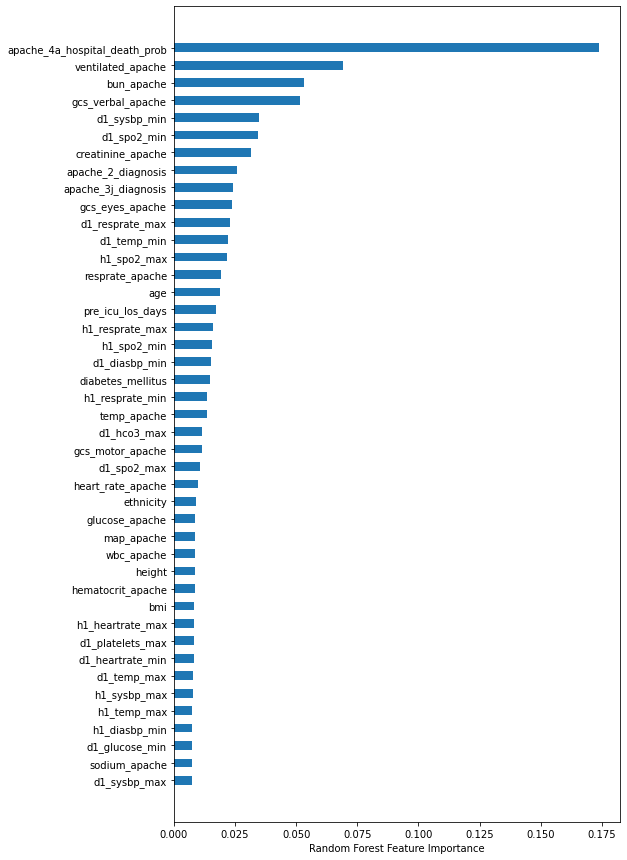

In [4]:
# Find feature importances computed by the RF model and sort them in descending order
# feature_importances_: The importance of a feature is computed as the (normalized) total 
# reduction of the criterion brought by that feature. It is also known as the Gini importance.
sorted_idx = RF_classifier.feature_importances_.argsort()

# make a bar plot of column names versus feature importances
plt.figure(figsize=(8,15))
plt.barh(X_train.columns[sorted_idx[25:68]], RF_classifier.feature_importances_[sorted_idx[25:68]], 
height=0.5)
plt.xlabel("Random Forest Feature Importance")

# Step 11. Validation

'hospital_death' probabilities are to be generated for the unlabeled dataset and uploaded on the competition website where the performance can be evaluated. Submissions are evaluated on the Area under the Receiver Operating Characteristic (ROC) curve between the predicted mortality and the observed target (hospital_death). The submission link is **https://www.kaggle.com/c/widsdatathon2020/submit**

To produce the submission file in the required format, encounter IDs and their hospital death probabilities are to be saved in a CSV file.

After uploading my submission file on the competition website, I obtained an AUC-ROC score of 0.883, which is very close to the one obtained by the winning approach (i.e., 0.915).

In [5]:
# Predict class probabilities for samples in the training dataset
# The predicted class probabilities of an input sample are computed as the mean predicted 
# class probabilities of the trees in the forest. The class probability of a single tree 
# is the fraction of samples of the same class in a leaf.
prob = RF_classifier.predict_proba(unlabeled)[:,1]

In [8]:
# create a dataframe in the format that is required for submission, i.e., two columns with
# encounter ID and hospital death probability
submission = pd.DataFrame({'encounter_id': unlabeled_encounter_id.astype(int), 'hospital_death': prob})

# save the submission dataframe in a csv file 
submission.to_csv("submission.csv", index=False)

# Conclusion

Working on this project has been a great learning experience since I am new to data science as well as to Python programming and VS Code software. I am happy that I obtained a reasonable performance score despite the very simple approach I followed. Because of the shortage of time and computer memory, I had to face the following limitations:
* For each step of the process, I implemented only one method, e.g., I used only Random Forest to make the classifier. Trying other methods and choosing the best one could possibly have produced better results.
* I did not optimize the hyperparameters of any of my algorithms. Optimum values of hyperparameters could possibly have produced better results.
* I implemented only 9 preprocessing steps. More preprocessing steps could possibly have produced better results.